In [141]:
import pandas as pd

accel_data = pd.read_csv("Linear accelerometer.csv")
gps_data = pd.read_csv("Location.csv")

print("Accelerometer Data:")
print(accel_data.head())

print("\nGPS Data:")
print(gps_data.head())


Accelerometer Data:
   Time (s)  X (m/s^2)  Y (m/s^2)  Z (m/s^2)
0  0.026479   0.701224   0.116141   0.095532
1  0.036526   0.695610   0.111246  -0.037422
2  0.046573   0.649644   0.079089  -0.222204
3  0.056620   0.598027   0.038298  -0.336624
4  0.066667   0.563035  -0.032920  -0.221826

GPS Data:
   Time (s)  Latitude (°)  Longitude (°)  Height (m)  Velocity (m/s)  \
0  0.016206     65.011318      25.466822   15.433350             NaN   
1  0.016206     65.011316      25.466820   15.436053             NaN   
2  5.516990     65.011466      25.466956   15.566354             NaN   
3  6.468167     65.011251      25.467001   16.454104        1.897016   
4  7.468182     65.011187      25.466986   18.096943        0.753084   

   Direction (°)  Horizontal Accuracy (m)  Vertical Accuracy (°)  
0            NaN                35.000000              18.738607  
1            NaN                35.000000              15.893019  
2            NaN               118.609938              19.017481 

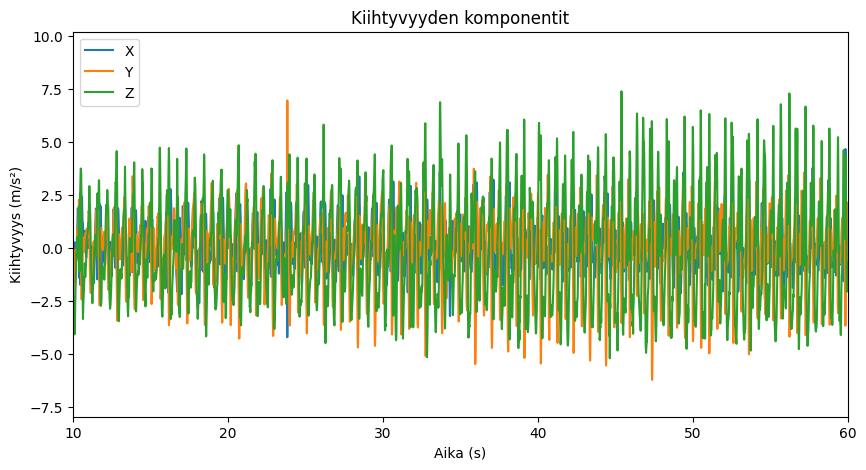

In [142]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(accel_data["Time (s)"], accel_data["X (m/s^2)"], label="X")
plt.plot(accel_data["Time (s)"], accel_data["Y (m/s^2)"], label="Y")
plt.plot(accel_data["Time (s)"], accel_data["Z (m/s^2)"], label="Z")
plt.xlabel("Aika (s)")
plt.ylabel("Kiihtyvyys (m/s²)")
plt.title("Kiihtyvyyden komponentit")
plt.xlim(10, 60)
plt.legend()
plt.show()


Askelmäärä suodatetusta kiihtyvyysdatasta: 382


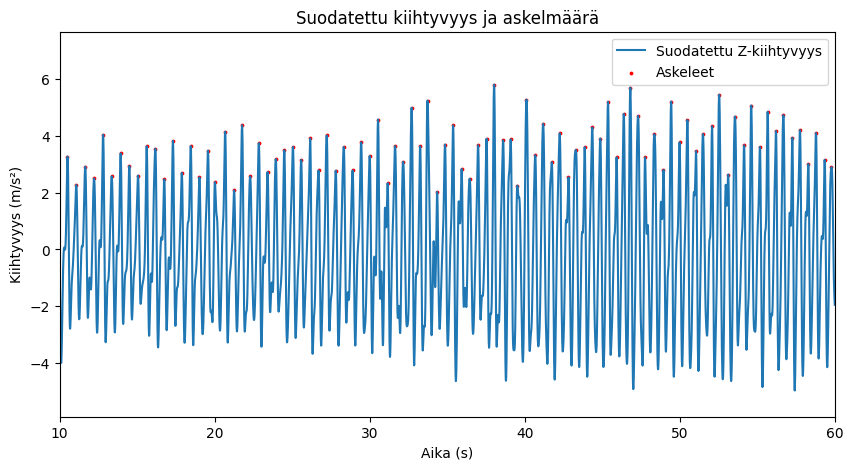

In [143]:
from scipy.signal import butter, filtfilt, find_peaks

def butter_lowpass_filter(data, cutoff=2.5, fs=50, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

filtered_acc = butter_lowpass_filter(accel_data["Z (m/s^2)"])

peaks, _ = find_peaks(filtered_acc, distance=40)

step_count_filtered = len(peaks)

print(f"Askelmäärä suodatetusta kiihtyvyysdatasta: {step_count_filtered}")

plt.figure(figsize=(10, 5))
plt.plot(accel_data["Time (s)"], filtered_acc, label="Suodatettu Z-kiihtyvyys")
plt.scatter(accel_data["Time (s)"].iloc[peaks], filtered_acc[peaks], color='red', label="Askeleet", s=3)
plt.xlabel("Aika (s)")
plt.ylabel("Kiihtyvyys (m/s²)")
plt.xlim(10, 60)
plt.legend()
plt.title("Suodatettu kiihtyvyys ja askelmäärä")
plt.show()


In [144]:
import numpy as np

lat_rad = np.radians(gps_data["Latitude (°)"])
lon_rad = np.radians(gps_data["Longitude (°)"])

R = 6371000  

distances = R * np.sqrt(
    (lat_rad.diff())**2 + (np.cos(lat_rad) * lon_rad.diff())**2
)

total_distance = distances.sum()

time_elapsed = gps_data["Time (s)"].iloc[-1] - gps_data["Time (s)"].iloc[0]
mean_speed = total_distance / time_elapsed

step_length = total_distance / len(peaks)

print(f"Kuljettu matka: {total_distance:.2f} m")
print(f"Keskinopeus: {mean_speed:.2f} m/s")
print(f"Askelpituus: {step_length:.2f} m")


Kuljettu matka: 332.08 m
Keskinopeus: 1.62 m/s
Askelpituus: 0.87 m


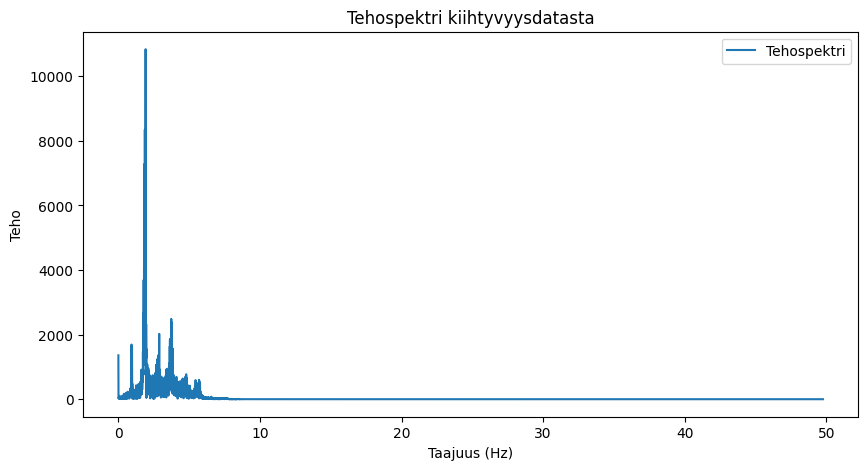

Askelmäärä Fourier-analyysin perusteella: 396


In [ ]:
from scipy.fft import fft, fftfreq

#fourier-analyysi
N = len(filtered_acc)
T = accel_data["Time (s)"].iloc[1] - accel_data["Time (s)"].iloc[0]
freqs = fftfreq(N, T)
fft_values = fft(filtered_acc)

plt.figure(figsize=(10, 5))
plt.plot(freqs[:N // 2], abs(fft_values[:N // 2]), label="Tehospektri")
plt.xlabel("Taajuus (Hz)")
plt.ylabel("Teho")
plt.title("Tehospektri kiihtyvyysdatasta")
plt.legend()
plt.show()

valid_range = (freqs > 0.5) & (freqs < 3)
peak_freq = freqs[valid_range][abs(fft_values[valid_range]).argmax()]

step_count_fft = peak_freq * (accel_data["Time (s)"].iloc[-1] - accel_data["Time (s)"].iloc[0])

print(f"Askelmäärä Fourier-analyysin perusteella: {step_count_fft:.0f}")


In [ ]:
import folium

m = folium.Map(location=[gps_data["Latitude (°)"].mean(), gps_data["Longitude (°)"].mean()], zoom_start=16)
route = list(zip(gps_data["Latitude (°)"], gps_data["Longitude (°)"]))
folium.PolyLine(route, color="blue", weight=3).add_to(m)

m
